In [155]:
import pandas as pd
import numpy as np
import math
import datetime as dt

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from plotly.offline import plot, iplot, init_notebook_mode

In [156]:
n_estimators = 100
max_depth = 5
gamma = 0
learning_rate = 0.1            
min_child_weight = 2           
subsample = 0.9                 
colsample_bytree = 1.0          
colsample_bylevel = 1.0        

In [157]:
data=pd.read_csv('bitcoin2020.csv')
data = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})

In [158]:
data.drop(['Timestamp'], axis=1, inplace=True)

In [160]:
data.tail()

,date,close,high,low,open
17372,30/06/2021 23:00,34354.16443,34623.02158,34170.96794,34592.10592
17373,30/06/2021 23:15,34300.00000,34365.35533,34168.27040,34347.00000
17374,30/06/2021 23:30,34162.60044,34351.54553,34153.26601,34293.79236
17375,30/06/2021 23:45,34196.41458,34299.00000,34082.40048,34169.49993
17376,01/07/2021 00:00,34206.68929,34289.70756,34052.39160,34192.50800


In [161]:
data.shape

(17377, 5)

In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17377 entries, 0 to 17376
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    17377 non-null  object 
 1   close   17377 non-null  float64
 2   high    17377 non-null  float64
 3   low     17377 non-null  float64
 4   open    17377 non-null  float64
dtypes: float64(4), object(1)
memory usage: 678.9+ KB


In [163]:
data.isna().any()

date     False
close    False
high     False
low      False
open     False
dtype: bool

In [164]:
data['date'] = pd.to_datetime(data.date, format='%d/%m/%Y %H:%M')
data.head()

,date,close,high,low,open
0,2021-01-01 00:00:00,28650.16625,28813.59019,28626.72316,28774.07118
1,2021-01-01 00:15:00,28634.95533,28732.62784,28564.10041,28649.16628
2,2021-01-01 00:30:00,28463.31375,28681.99801,28463.31375,28645.89113
3,2021-01-01 00:45:00,28384.28072,28559.13232,28315.10000,28475.53020
4,2021-01-01 01:00:00,28566.10876,28566.10876,28375.25696,28375.44729


In [165]:
data['range_high_low'] = data['high'] - data['low']
data.drop(['high', 'low'], axis=1, inplace=True)
data['range_open_close'] = data['open'] - data['close']
data.drop(['open'], axis=1, inplace=True)
data_modified = data.copy()
price_df = data['close']

In [166]:
data_modified

,date,close,range_high_low,range_open_close
0,2021-01-01 00:00:00,28650.16625,186.86703,123.90493
1,2021-01-01 00:15:00,28634.95533,168.52743,14.21095
2,2021-01-01 00:30:00,28463.31375,218.68426,182.57738
3,2021-01-01 00:45:00,28384.28072,244.03232,91.24948
4,2021-01-01 01:00:00,28566.10876,190.85180,-190.66147
...,...,...,...,...
17372,2021-06-30 23:00:00,34354.16443,452.05364,237.94149
17373,2021-06-30 23:15:00,34300.00000,197.08493,47.00000
17374,2021-06-30 23:30:00,34162.60044,198.27952,131.19192
17375,2021-06-30 23:45:00,34196.41458,216.59952,-26.91465


In [167]:
date = data["date"]
date
date = np.array(date)
date

array(['2021-01-01T00:00:00.000000000', '2021-01-01T00:15:00.000000000',
       '2021-01-01T00:30:00.000000000', ...,
       '2021-06-30T23:30:00.000000000', '2021-06-30T23:45:00.000000000',
       '2021-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [168]:
print("Starting date: ",data.iloc[0][0])
print("Ending date: ", data.iloc[-1][0])
print("Duration: ", data.iloc[-1][0]-data.iloc[0][0])

Starting date:  2021-01-01 00:00:00
Ending date:  2021-07-01 00:00:00
Duration:  181 days 00:00:00


In [169]:
data_modified.shape

(17377, 4)

In [170]:
df = data_modified.copy()
print("Total data for prediction: ",df.shape[0])

Total data for prediction:  17377


In [171]:
del df['date']

In [172]:
scaler=MinMaxScaler(feature_range=(0,1))
X=scaler.fit_transform(df)
data_scaled = pd.DataFrame(X, columns=df.columns,
                          index=df.index)

In [173]:
data_scaled

,close,range_high_low,range_open_close
0,0.007319,0.035956,0.484746
1,0.006900,0.032427,0.467706
2,0.002175,0.042078,0.493860
3,0.000000,0.046955,0.479673
4,0.005005,0.036723,0.435881
...,...,...,...
17372,0.164325,0.086981,0.502461
17373,0.162834,0.037922,0.472800
17374,0.159052,0.038152,0.485878
17375,0.159983,0.041677,0.461318


In [174]:
N = 2
data_processed = data_scaled.copy()
for i in range(1,N+1):
    data_shifted = data_scaled.shift(i)
    
    data_shifted = data_shifted.rename(columns={'close': 'close_lag'+str(i),'volume':'volume_lag'+str(i),'range_high_low':'range_high_low_lag'+str(i),
                                         'range_open_close':'range_open_close_lag'+str(i)})
    data_processed = pd.concat([data_processed,data_shifted],axis=1)
data_processed

,close,range_high_low,range_open_close,close_lag1,range_high_low_lag1,range_open_close_lag1,close_lag2,range_high_low_lag2,range_open_close_lag2
0,0.007319,0.035956,0.484746,NaN,NaN,NaN,NaN,NaN,NaN
1,0.006900,0.032427,0.467706,0.007319,0.035956,0.484746,NaN,NaN,NaN
2,0.002175,0.042078,0.493860,0.006900,0.032427,0.467706,0.007319,0.035956,0.484746
3,0.000000,0.046955,0.479673,0.002175,0.042078,0.493860,0.006900,0.032427,0.467706
4,0.005005,0.036723,0.435881,0.000000,0.046955,0.479673,0.002175,0.042078,0.493860
...,...,...,...,...,...,...,...,...,...
17372,0.164325,0.086981,0.502461,0.171097,0.028361,0.458108,0.170355,0.020283,0.470182
17373,0.162834,0.037922,0.472800,0.164325,0.086981,0.502461,0.171097,0.028361,0.458108
17374,0.159052,0.038152,0.485878,0.162834,0.037922,0.472800,0.164325,0.086981,0.502461
17375,0.159983,0.041677,0.461318,0.159052,0.038152,0.485878,0.162834,0.037922,0.472800


In [175]:
data_processed = data_processed[N:]
data_processed

,close,range_high_low,range_open_close,close_lag1,range_high_low_lag1,range_open_close_lag1,close_lag2,range_high_low_lag2,range_open_close_lag2
2,0.002175,0.042078,0.493860,0.006900,0.032427,0.467706,0.007319,0.035956,0.484746
3,0.000000,0.046955,0.479673,0.002175,0.042078,0.493860,0.006900,0.032427,0.467706
4,0.005005,0.036723,0.435881,0.000000,0.046955,0.479673,0.002175,0.042078,0.493860
5,0.007537,0.029610,0.451208,0.005005,0.036723,0.435881,0.000000,0.046955,0.479673
6,0.009100,0.033616,0.454394,0.007537,0.029610,0.451208,0.005005,0.036723,0.435881
...,...,...,...,...,...,...,...,...,...
17372,0.164325,0.086981,0.502461,0.171097,0.028361,0.458108,0.170355,0.020283,0.470182
17373,0.162834,0.037922,0.472800,0.164325,0.086981,0.502461,0.171097,0.028361,0.458108
17374,0.159052,0.038152,0.485878,0.162834,0.037922,0.472800,0.164325,0.086981,0.502461
17375,0.159983,0.041677,0.461318,0.159052,0.038152,0.485878,0.162834,0.037922,0.472800


In [176]:
# data_processed.to_csv("ETH_processed.csv",index=False)

In [177]:
labels = data_processed['close']
labels
features = data_processed.copy()
features.drop(['close','range_high_low','range_open_close'], axis=1, inplace=True)
features

,close_lag1,range_high_low_lag1,range_open_close_lag1,close_lag2,range_high_low_lag2,range_open_close_lag2
2,0.006900,0.032427,0.467706,0.007319,0.035956,0.484746
3,0.002175,0.042078,0.493860,0.006900,0.032427,0.467706
4,0.000000,0.046955,0.479673,0.002175,0.042078,0.493860
5,0.005005,0.036723,0.435881,0.000000,0.046955,0.479673
6,0.007537,0.029610,0.451208,0.005005,0.036723,0.435881
...,...,...,...,...,...,...
17372,0.171097,0.028361,0.458108,0.170355,0.020283,0.470182
17373,0.164325,0.086981,0.502461,0.171097,0.028361,0.458108
17374,0.162834,0.037922,0.472800,0.164325,0.086981,0.502461
17375,0.159052,0.038152,0.485878,0.162834,0.037922,0.472800


In [178]:
labels

2        0.002175
3        0.000000
4        0.005005
5        0.007537
6        0.009100
           ...   
17372    0.164325
17373    0.162834
17374    0.159052
17375    0.159983
17376    0.160266
Name: close, Length: 17375, dtype: float64

In [179]:
def create_dataset(features, labels, test_prop = 0.15):
    train_size=int(len(features)*(1-test_prop))
    X_train = features[:train_size]
    Y_train = labels[:train_size]
    X_test = features[train_size:]
    Y_test = labels[train_size:]
    return np.array(X_train), np.array(Y_train),np.array(X_test),np.array(Y_test),train_size

In [180]:
X_train,Y_train,X_test,Y_test, train_size = create_dataset(features,labels,0.15)
print("X_train: ", X_train.shape)
print("y_train: ", Y_train.shape)
print("X_test: ", X_test.shape)
print("Y_test", Y_test.shape)

X_train:  (14768, 6)
y_train:  (14768,)
X_test:  (2607, 6)
Y_test (2607,)


In [186]:
my_model = XGBRegressor(n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight,
                    colsample_bylevel=colsample_bylevel,
                    colsample_bytree=colsample_bytree,
                       gamma=gamma,
                       subsample=subsample)
my_model.fit(X_train, Y_train)
predictions = my_model.predict(X_test)
print("Mean Absolute Percentage Error - MAPE : " + str(mean_absolute_percentage_error(Y_test, predictions)*100)+"%")
# print("Mean Absolute Error - MAE : " + str(mean_absolute_error(Y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(Y_test, predictions))))

Mean Absolute Percentage Error - MAPE : 2.3505098302933987%
Root Mean squared Error - RMSE : 0.005228684635744611


In [187]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (14768, 1)
Test data prediction: (2607, 1)


In [188]:
scaler1=MinMaxScaler(feature_range=(0,1))
Y=scaler1.fit_transform(np.array(price_df).reshape(-1,1))
# data_price = pd.DataFrame(Y, columns=price_df.columns,
#                           index=price_df.index)
train_predict = scaler1.inverse_transform(train_predict)
test_predict = scaler1.inverse_transform(test_predict)
original_ytrain = scaler1.inverse_transform(Y_train.reshape(-1,1)) 
original_ytest = scaler1.inverse_transform(Y_test.reshape(-1,1)) 
print("Mean Absolute Percentage Error - MAPE : " + str(mean_absolute_percentage_error(original_ytest, test_predict)*100)+"%")
# print("Mean Absolute Error - MAE : " + str(mean_absolute_error(Y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(original_ytest, test_predict))))
print("R2 : " + str(r2_score(original_ytest, test_predict)))

Mean Absolute Percentage Error - MAPE : 0.3872737716470976%
Root Mean squared Error - RMSE : 189.9565452930035
R2 : 0.9936724869847615


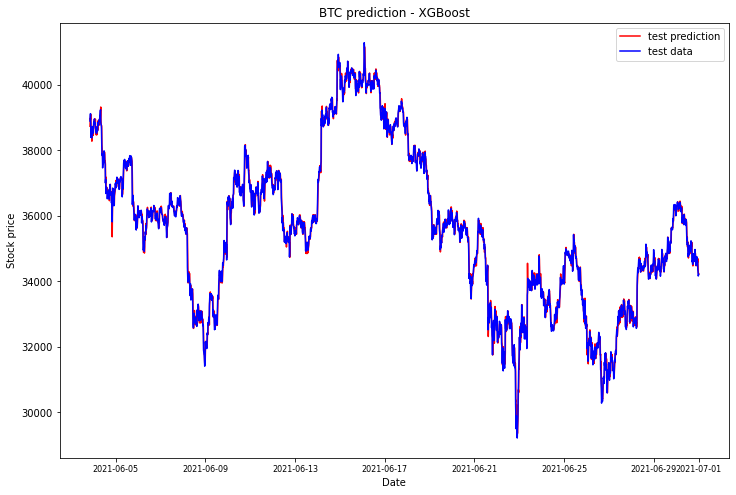

In [192]:
plt.figure(figsize=[12,8])
plt.plot(date[2+train_size:],test_predict,color="red", label = "test prediction")
plt.plot(date[2+train_size:],original_ytest,color = "blue",label = "test data")
# plt.plot(date[2:-219],original_ytrain, color = "green")
plt.title("BTC prediction - XGBoost")
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.xticks(fontsize = 8)
plt.legend()
plt.show()